 Problem Overview
 

Online product reviews provided by consumers who previously purchased products have become a major information source for consumers and marketers regarding product quality. Research has shown that consumer online product ratings reflect both the customers' experience with the product and the influence of others' ratings.
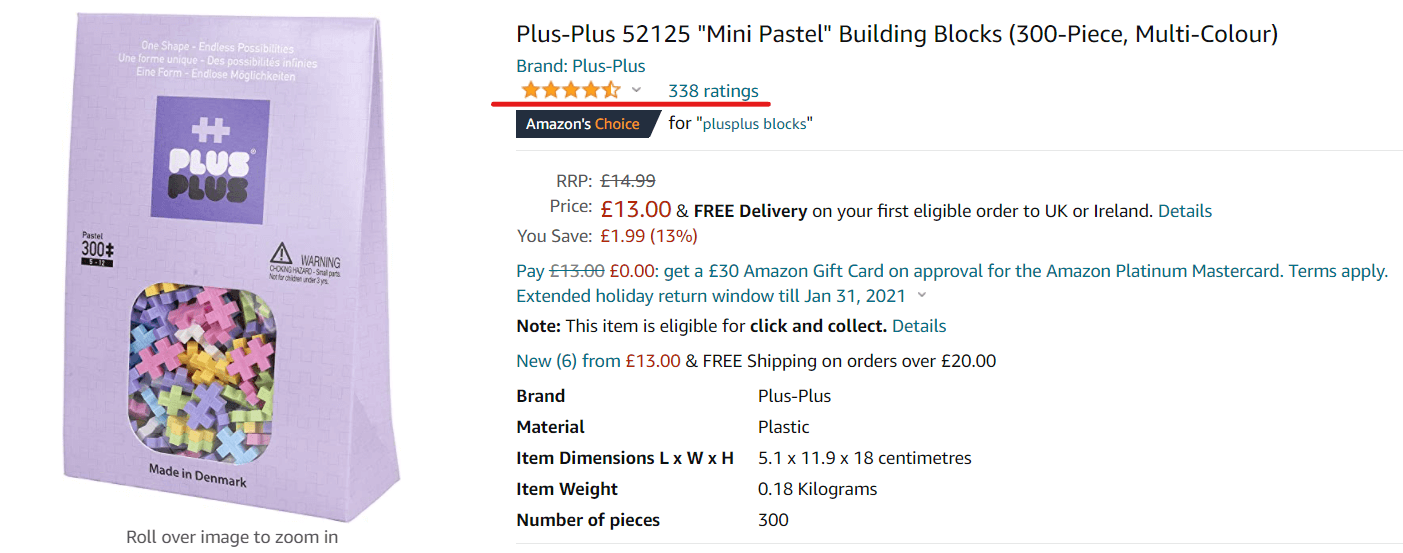


Websites prominently display consumers' product ratings, which influence consumers' buying decisions and willingness to pay.

We are providing you with some sample products information, their descriptions and reviews from the customers to analyze ratings, prices, and reviews. At the same time, we also want you to use your NLP and ML skills to predict the rating for a particular product.

 

 
Objective
 

You are required to build a machine learning model to predict the product rating out of 5.

 

 

About the Data
 

There are 16 independent variables and 1 dependent variable. There are nearly 10k observations combining both train and test dataset

 

 

Data Description

uniq_id

product_name

manufacturer

price

number_available_in_stock

number_of_reviews

number_of_answered_questions

average_review_rating

amazon_category_and_sub_category

customers_who_bought_this_item_also_bought

description 

product_information 

product_description 

items_customers_buy_after_viewing_this_item 

customer_questions_and_answers 

customer_reviews 

sellers 

 

In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import re
train_df = pd.read_csv('/content/Train_Data.csv')
test_df = pd.read_csv('/content/Test_Data.csv')

In [ ]:
train_df

,uniq_id,product_name,manufacturer,price,number_available_in_stock,number_of_reviews,number_of_answered_questions,amazon_category_and_sub_category,customers_who_bought_this_item_also_bought,description,product_information,product_description,items_customers_buy_after_viewing_this_item,customer_questions_and_answers,customer_reviews,sellers,average_review_rating
0,7f890f73298badd692c39c3801ef1d28,Batman - Role Play - Cowl and Batarang,Mattel,£14.99,NaN,4,1.0,Figures & Playsets > Science Fiction & Fantasy,http://www.amazon.co.uk/Rubies-Costume-Co-Flas...,"When kids aspire to be like Batman, it's easy ...",Technical Details Item Weight113 g Product Dim...,"When kids aspire to be like Batman, it's easy ...",http://www.amazon.co.uk/Rubies-Costume-Co-Flas...,NaN,Item was broken // 3.0 // 2 April 2014 // By\n...,"{""seller""=>{""Seller_name_1""=>""a1 Toys"", ""Selle...",4.5
1,83e55a2edb6c13dfc1c46d1577321b2e,Doctor Who 12-inch 50th Anniversary Collector ...,Dr Who,NaN,3 new,73,NaN,Figures & Playsets > Science Fiction & Fantasy,http://www.amazon.co.uk/Doctor-Who-Classic-Dal...,Product Description This ultimate Doctor Who c...,Technical Details Item Weight1.4 Kg Product Di...,Product Description This ultimate Doctor Who c...,http://www.amazon.co.uk/Dr-Who-Dalek-Projectio...,NaN,A wonderful collectors piece // 5.0 // 31 Aug....,NaN,4.6
2,4bfaaf6558582a0f337ad59fcd51fcf7,Melissa & Doug Sticker Collection - Pink,Melissa & Doug,£4.76,15 new,47,1.0,Arts & Crafts > Paper & Stickers,http://www.amazon.co.uk/Melissa-Doug-Sticker-C...,"Product Description Cute couture, adorable ani...",Technical Details Item Weight299 g Product Dim...,"Product Description Cute couture, adorable ani...",http://www.amazon.co.uk/Melissa-Doug-Habitats-...,NaN,Great sticker collection // 5.0 // 19 Jun. 201...,NaN,4.7
3,4e6702cb7fe9278f16dedc39a8808c72,"Rock and Roll Cards, 30 Team",ClubKing Ltd,£4.49,2 new,2,1.0,Hobbies > Trading Cards & Accessories > Packs ...,http://www.amazon.co.uk/ClubKing-Ltd-Football-...,"1 Pack of 25 Football Cards, 30 rockstars on e...",Technical Details Item Weight100 g Product Dim...,"1 Pack of 25 Football Cards, 30 rockstars on e...",http://www.amazon.co.uk/ClubKing-Ltd-Football-...,how many cards in a pack it dosn't say..?? // ...,Rock and roll cards // 5.0 // 28 July 2013 // ...,"{""seller""=>[{""Seller_name_1""=>""ClubKing Ltd"", ...",5.0
4,f505611d18b0ae98258896ae1b0f14c8,Crayola 16 Pipsqueak Glitter Glues,Crayola,£5.99,9 new,10,1.0,Characters & Brands > Crayola,http://www.amazon.co.uk/Crayola-3-3542-9-Glitt...,Product Description 16 Pipsqueak washable glit...,Technical Details Item Weight186 g Product Dim...,Product Description 16 Pipsqueak washable glit...,http://www.amazon.co.uk/Crayola-3-3542-9-Glitt...,NaN,Little fingers big imagination // 5.0 // 4 Mar...,"{""seller""=>[{""Seller_name_1""=>""BIC WAREHOUSE"",...",4.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7481,e11f105f69efdcbfaa58abab1547a600,Oxford Diecast Devon and Somerset F and R MAN ...,Oxford Diecast,£16.43,2 new,1,1.0,Die-Cast & Toy Vehicles > Toy Vehicles & Acces...,NaN,"Our model of the very modern fire appliance, r...",Technical Details Item Weight82 g Product Dime...,"Our model of the very modern fire appliance, r...",NaN,NaN,Oxford 1/76 Devon & Somerset F and R Man Pump ...,"{""seller""=>[{""Seller_name_1""=>""Models4hobby"", ...",4.0
7482,f96be42af5602b6cc5e67e7ad59280ad,Polyhedral 7-Die Borealis Dice Set - Sky Blue ...,Chessex,£11.01,4 new,1,1.0,Games > Dice & Dice Games,http://www.amazon.co.uk/Polyhedral | http://ww...,Signature dice are a compilation of the best s...,Technical Details Item Weight54 g Product Dime...,Signature dice are a compilation of the best s...,http://www.amazon.co.uk/Polyhedral | http://ww...,NaN,"High quality product, Exceeded expectations //...",NaN,5.0
7483,3c1c6afb2551f1534d80c760e26127c6,ANGRY BIRDS Star Wars A4 Colouring Book,Alligator,NaN,4 used,6,2.0,Characters & Brands > Star Wars > Toys,http://www.amaz

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7486 entries, 0 to 7485
Data columns (total 17 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   uniq_id                                      7486 non-null   object 
 1   product_name                                 7486 non-null   object 
 2   manufacturer                                 7481 non-null   object 
 3   price                                        6417 non-null   object 
 4   number_available_in_stock                    5587 non-null   object 
 5   number_of_reviews                            7486 non-null   object 
 6   number_of_answered_questions                 6909 non-null   float64
 7   amazon_category_and_sub_category             7000 non-null   object 
 8   customers_who_bought_this_item_also_bought   6665 non-null   object 
 9   description                                  7013 non-null   object 
 10  

In [ ]:
def cat_depth(x) -> 'str':
  x = str(x)
  return x.split('>')[-1].strip()

c = train_df['amazon_category_and_sub_category'].apply(lambda x: cat_depth(x)) 
train_df.insert(8,'end_category',c)
c = test_df['amazon_category_and_sub_category'].apply(lambda x: cat_depth(x)) 
test_df.insert(8,'end_category',c)

In [ ]:
len(train_df['end_category'].unique()),len(test_df['end_category'].unique())

(219, 153)

In [ ]:
len(set(test_df['end_category'].unique()) - set(train_df['end_category'].unique()))

17

product_name                                 
manufacturer                                 
price: null-values cant be imputed and so rows must be dropped

number_available_in_stock: null-values can be replaced with 0

number_of_reviews: null-values can be replaced with 0    

number_of_answered_questions: null-values can be replaced with 0   

amazon_category_and_sub_category:  null-values can be replaced with similar items based on tfidf score of name     

customers_who_bought_this_item_also_bought: null-values can be replaced with 0   
  

description  : drop

product_information : drop

product_description  : drop

items_customers_buy_after_viewing_this_item : replace with 0  

customer_questions_and_answers:   drop column 

customer_reviews                              

sellers                                       

average_review_rating                         

In [ ]:
train_df.drop(['customer_questions_and_answers', 'description', 'product_information','product_description'], axis = 1, inplace=True)
test_df.drop(['customer_questions_and_answers', 'description', 'product_information','product_description'], axis = 1, inplace=True)
train_df.drop(train_df[train_df['price'].isna()].index, axis= 0, inplace=True)
test_df.drop(test_df[test_df['price'].isna()].index, axis= 0, inplace=True)

In [ ]:
def handle_missing_cols(df)-> pd.DataFrame:
  df['number_available_in_stock'][df['number_available_in_stock'].isna()] = 0
  df['number_of_reviews'][df['number_of_reviews'].isna()] = 0
  df['number_of_answered_questions'][df['number_of_answered_questions'].isna()] = 0
  df['amazon_category_and_sub_category'][df['amazon_category_and_sub_category'].isna()] = 'misc'
  df['customers_who_bought_this_item_also_bought'][df['customers_who_bought_this_item_also_bought'].isna()] = 0
  df['items_customers_buy_after_viewing_this_item'][df['items_customers_buy_after_viewing_this_item'].isna()] = 0
  df['manufacturer'][df['manufacturer'].isna()] = 'unknown'
  df['sellers'][df['sellers'].isna()] = 'unknown'
  df['customer_reviews'][df['customer_reviews'].isna()] = ' '
  return df

train_df = handle_missing_cols(train_df)
test_df = handle_missing_cols(test_df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from 

In [ ]:
def seller_unpacker(x) -> int:
  if type(x) == 'int':
    return x
  else:
    return len(x.split('Seller_name')) -1



def process_cols(df) -> pd.DataFrame:
  df['price'] = df['price'].apply(lambda x: float(x.split('£')[1].split()[0].replace(',','')))
  df['number_available_in_stock'] = df['number_available_in_stock'].astype('str')
  df['number_available_in_stock'] = df['number_available_in_stock'].apply(lambda x: int(x.split()[0]))
  df['number_available_in_stock'] = df['number_available_in_stock'].astype('int')
  df['number_of_reviews'] = df['number_of_reviews'].astype('str')
  df['number_of_reviews'] = df['number_of_reviews'].apply(lambda x: int(x.replace(',','')) )
  df['number_of_reviews'] = df['number_of_reviews'].astype('int')
  df['customers_who_bought_this_item_also_bought'] = df['customers_who_bought_this_item_also_bought'].astype('str')
  df['customers_who_bought_this_item_also_bought'] = df['customers_who_bought_this_item_also_bought'].apply(lambda x: len(x.split(' | ')) )
  df['customers_who_bought_this_item_also_bought'] = df['customers_who_bought_this_item_also_bought'].astype('int')
  df['items_customers_buy_after_viewing_this_item'] = df['items_customers_buy_after_viewing_this_item'].astype('str')
  df['items_customers_buy_after_viewing_this_item'] = df['items_customers_buy_after_viewing_this_item'].apply(lambda x: len(x.split(' | ')) )
  df['items_customers_buy_after_viewing_this_item'] = df['items_customers_buy_after_viewing_this_item'].astype('int')
  df['sellers'] = df['sellers'].apply(lambda x: seller_unpacker(x))
  df['sellers'] = df['sellers'].astype('int')
  return df
  
train_df = process_cols(train_df)
test_df = process_cols(test_df)

In [ ]:
train_df=train_df.reset_index()
train_df.drop('index', inplace=True, axis=1)

test_df=test_df.reset_index()
test_df.drop('index', inplace=True, axis=1)

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6417 entries, 0 to 6416
Data columns (total 14 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   uniq_id                                      6417 non-null   object 
 1   product_name                                 6417 non-null   object 
 2   manufacturer                                 6417 non-null   object 
 3   price                                        6417 non-null   float64
 4   number_available_in_stock                    6417 non-null   int64  
 5   number_of_reviews                            6417 non-null   int64  
 6   number_of_answered_questions                 6417 non-null   float64
 7   amazon_category_and_sub_category             6417 non-null   object 
 8   end_category                                 6417 non-null   object 
 9   customers_who_bought_this_item_also_bought   6417 non-null   int64  
 10  

In [ ]:
len(train_df['manufacturer'].unique())

2008

In [ ]:
D = train_df.copy()


def get_manufacturer_avg_rating(df) -> dict:
  '''returns manufacturer's avg rating by end category'''
  ratings_dict ={}
  print('Getting rating...')
  for manufacturer in df['manufacturer'].unique():

    D = df.groupby(by=['manufacturer']).get_group(manufacturer)
    ec_dict = {}
    for end_category in D['end_category'].unique():
      try:
        ec_dict[end_category] = D[D['end_category']==end_category]['average_review_rating'].mean()
      except:
        print(ec_dict)

    ratings_dict[manufacturer] =  ec_dict
  print('Done')
  return ratings_dict

ratings_dict = get_manufacturer_avg_rating(D)

Getting rating...
Done


In [ ]:
def replace_manufacturer(df) -> pd.DataFrame:
  for i in df.index:
    try:
      df['manufacturer'].iloc[i] = ratings_dict[df.iloc[i]['manufacturer']][df.iloc[i]['end_category']]
    except KeyError:
      print(df['manufacturer'].iloc[i])
      df['manufacturer'].iloc[i] = 3 #neutral rating
  return df['manufacturer']

train_df['manufacturer'] = replace_manufacturer(train_df)
test_df['manufacturer'] = replace_manufacturer(test_df)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Heidi Ott
Unknown
Beavis And Butt-Head
Berenguer
Games Workshop
Marvel
Animagic
Fabfancydress
Hornby
White Lab Mouse
Just Feathers by Crazy Grans
WWF
DRAGON / Aoshima
Force Attax
Ban Dai
Red, White and Blue
Stickers
Kaiyodo
Boppi
Learning Resources
LS Glamour Room
Plush
GoKi
AT
Metal products
Monster Parties
Viga
Posh Paws
Matchbox 1-75
Wizards of the Coast
Playwrite
Alex
Zombie Zity
Lord of the Rings
Living Puppets
M:Tech
Wild and Wolf
Bob
Reeves
Freeing
TY-P2C
Hawk Wargames
Learning Resources
Tobar
The Toy Jar
Just For Fun
Giochi Preziosi
NPW
Nintendogs
Sonic The Hedgehog
Pokemon pikachu
Jilong
Biestle
Lite Brix Moonlight Monsters
Monster High
K and C, K and C
ILOVEFANCYDRESS
Olympic Mascots
Click-A-Brick
Sambro
Kinetic Sand
Air Storm
Mammut
Walkera
Aquarius
Bruder
Schleich
Skylanders Swap Force Tin
Papo Knights
Craftime
Ferrari
Linxinwei
SES Creative
Dickie Toys
Animal Babies
Train Tech
OnlineDiscountStore
Zebra Boutique
Tober
Lanard
TMNT
Amigo Spiel + Freizeit
James Bond
Hallmark
C

In [ ]:
train_df

,uniq_id,product_name,manufacturer,price,number_available_in_stock,number_of_reviews,number_of_answered_questions,amazon_category_and_sub_category,end_category,customers_who_bought_this_item_also_bought,items_customers_buy_after_viewing_this_item,customer_reviews,sellers,average_review_rating
0,7f890f73298badd692c39c3801ef1d28,Batman - Role Play - Cowl and Batarang,4.56667,14.99,0,4,1.0,Figures & Playsets > Science Fiction & Fantasy,Science Fiction & Fantasy,6,4,Item was broken // 3.0 // 2 April 2014 // By\n...,1,4.5
1,4bfaaf6558582a0f337ad59fcd51fcf7,Melissa & Doug Sticker Collection - Pink,4.56667,4.76,15,47,1.0,Arts & Crafts > Paper & Stickers,Paper & Stickers,6,4,Great sticker collection // 5.0 // 19 Jun. 201...,0,4.7
2,4e6702cb7fe9278f16dedc39a8808c72,"Rock and Roll Cards, 30 Team",4.68,4.49,2,2,1.0,Hobbies > Trading Cards & Accessories > Packs ...,Packs & Sets,6,4,Rock and roll cards // 5.0 // 28 July 2013 // ...,2,5.0
3,f505611d18b0ae98258896ae1b0f14c8,Crayola 16 Pipsqueak Glitter Glues,4.65,5.99,9,10,1.0,Characters & Brands > Crayola,Crayola,6,4,Little fingers big imagination // 5.0 // 4 Mar...,9,4.2
4,7e3e6576619a0176eb79a5cd223736b1,MANDALORIAN SUPER COMMANDO - LEGO Star Wars Mi...,4.72794,11.95,0,1,1.0,Characters & Brands > Star Wars > Toys,Toys,6,4,Four Stars // 4.0 // 25 Feb. 2015 // By\n \...,0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6412,b65c393eb6e07ca6a0b2da5f9ae43c4e,Brookite Triple Nylon Pinwheel,4.53571,9.20,4,42,2.0,Sports Toys & Outdoor > Kites & Flight Toys,Kites & Flight Toys,6,4,Pinwheel Magic! // 4.0 // 26 Jun. 2013 // By\n...,4,4.3
6413,e11f105f69efdcbfaa58abab1547a600,Oxford Diecast Devon and Somerset F and R MAN ...,4.79661,16.43,2,1,1.0,Die-Cast & Toy Vehicles > Toy Vehicles & Acces...,Vehicles,1,1,Oxford 1/76 Devon & Somerset F and R Man Pump ...,2,4.0
6414,f96be42af5602b6cc5e67e7ad59280ad,Polyhedral 7-Die Borealis Dice Set - Sky Blue ...,4.695,11.01,4,1,1.0,Games > Dice & Dice Games,Dice & Dice Games,6,2,"High quality product, Exceeded expectations //...",0,5.0
6415,0ae74767fc8b6ec11813000c46e56c44,Foxmind Map It!,4,10.00,5,1,1.0,Games > Educational Games,Educational Games,6,4,"fun, educational // 4.0 // 14 Jan. 2013 // By\...",0,4.0


In [18]:
test_df

,uniq_id,product_name,manufacturer,price,number_available_in_stock,number_of_reviews,number_of_answered_questions,amazon_category_and_sub_category,end_category,customers_who_bought_this_item_also_bought,items_customers_buy_after_viewing_this_item,customer_reviews,sellers
0,90093bd02c6d5ce6d6c8f2e2af411fc1,Dolls House Miniature Cats x2,3,12.00,0,1,1.0,Dolls & Accessories > Dolls' House Dolls & Acc...,Dolls' House Accessories,1,1,Dolls house miniatures // 5.0 // 9 Jan. 2013 /...,1
1,0fcde78856668c1563f54650b17620e7,My Pirate Party Music CD,3,4.99,1,6,1.0,Figures & Playsets > Pirates,Pirates,6,4,Okay but that's all // 1.0 // 11 July 2011 // ...,1
2,69a9becbd60381a4eb7cdafe30761ee4,1ST BIRTHDAY BANNER GIRL (BGC HOLOGRAPHIC) 9FT...,4.82424,1.49,5,22,1.0,"Party Supplies > Banners, Stickers & Confetti ...",Banners,6,4,Good quality but take down carefully as the fo...,0
3,18bc8b988f43f352b946a253642e1c6e,Beavis and Butt-Head Great Cornholio Bobble Head,3,84.43,0,1,1.0,Hobbies > Collectible Figures & Memorabilia > ...,Bobbleheads & Busts,1,1,hilarious // 5.0 // 11 Dec. 2013 // By\n \n...,1
4,6288673a2bbe7a0f866e1ec722796725,Harley Davidson Motorcycle Die-Cast Metal Kit ...,4.56429,9.06,14,14,1.0,Die-Cast & Toy Vehicles > Toy Vehicles & Acces...,Vehicles,6,4,Not exactly what I expected. // 3.0 // 14 May ...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2128,dc9d8256cee4a2561109f54ca102c2c8,"Fiddle Kit - 3 genuine Tangle Jr (Yellow, Whit...",5,6.95,0,1,3.0,Jigsaws & Puzzles > 3-D Puzzles,3-D Puzzles,6,2,Like them but prefer the wooden blocks as I fi...,1
2129,f43ed33e08477157166a94a124f28e69,Jake and the Neverland Pirates Figures Izzy an...,4.4,6.50,8,11,1.0,Figures & Playsets > Pirates,Pirates,6,4,Izzy from Jack & the Neverland Pirates // 5.0 ...,8
2130,68a37abe302b06b41de0620e576f766a,VW T25 Camper - Bamboo Yellow,4.79661,10.44,3,1,3.0,Die-Cast & Toy Vehicles > Toy Vehicles & Acces...,Vehicles,6,4,Five Stars // 5.0 // 4 Nov. 2015 // By\n \n...,3
2131,211e40c3189177f89afb30ee0744e80f,Hornby Gauge EWS Bo-Bo Diesel Electric Class 6...,4.71765,121.05,3,1,5.0,Hobbies > Model Trains & Railway Sets > Rail V...,Locomotives,6,1,Excellent running engine just had it chipped t...,0


In [ ]:
train_df.drop(['product_name', 'amazon_category_and_sub_category',	'end_category'], inplace=True, axis = 1)
test_df.drop(['product_name', 'amazon_category_and_sub_category',	'end_category'], inplace=True, axis = 1)

In [86]:
def keep_reviews_only(p) -> list:
  try:
    p = p.lower().split('//')
  except:
    print(p)
    return list(p)
  i = [j for j in range(len(p)) if j%4 ==0]
  l = [p[m] for m in i]
  return l

train_df['customer_reviews'] = train_df['customer_reviews'].apply(lambda x: keep_reviews_only(x))
test_df['customer_reviews'] = test_df['customer_reviews'].apply(lambda x: keep_reviews_only(x))

In [88]:
train_df.iloc[1]['customer_reviews']

['great sticker collection ',
 ' lovely sticker collection. each page is themed so plenty of choice and good range of stickers.great for birthday party gifts and rainy days as there are plenty of stickers so you can make some really imaginative pictures or cards. also like the sticker collection for boys. another great from melissa & doug. | not as good as other m&d sticker books ',
 ' the stickers are rather small, difficult to detach without tearing and sometimes repetitive (even a 4 year-old gets bored with so many fairies based on 4 designs). it does not hold the attention like the others. because i had previously bought the excellent habitats book with plastic re-usable stickers i did not realise these were not. will be more particular next time and pay the extra for lasting appeal. | a hit with the five year old friend we gave this to ',
 ' very pleased with this sticker selection. there is literally hours of entertainment for a child into sticking. they do various themes and all

In [98]:
import nltk
#nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()
sia.polarity_scores("Wow, NLTK is really powerful | five stars")

{'compound': 0.7841, 'neg': 0.0, 'neu': 0.42, 'pos': 0.58}

In [104]:
def get_sentiment_score(x,sent) -> float:
  sen_score = []
  for i in x:
    sen_score.append(sia.polarity_scores(i)[sent])
  return round(np.array(sen_score).mean(), 3)
get_sentiment_score(train_df.iloc[1]['customer_reviews'], 'pos')

train_df['positive_sentiment'] = train_df['customer_reviews'].apply(lambda x: get_sentiment_score(x,'pos'))
test_df['positive_sentiment'] = test_df['customer_reviews'].apply(lambda x:  get_sentiment_score(x,'pos'))


train_df['negaitive_sentiment'] = train_df['customer_reviews'].apply(lambda x: get_sentiment_score(x,'neg'))
test_df['negaitive_sentiment'] = test_df['customer_reviews'].apply(lambda x:  get_sentiment_score(x,'neg'))


train_df['neutral_sentiment'] = train_df['customer_reviews'].apply(lambda x: get_sentiment_score(x,'neu'))
test_df['neutral_sentiment'] = test_df['customer_reviews'].apply(lambda x:  get_sentiment_score(x,'neu'))

In [105]:
train_df

,uniq_id,product_name,manufacturer,price,number_available_in_stock,number_of_reviews,number_of_answered_questions,amazon_category_and_sub_category,end_category,customers_who_bought_this_item_also_bought,items_customers_buy_after_viewing_this_item,customer_reviews,sellers,average_review_rating,positive_sentiment,negaitive_sentiment,neutral_sentiment
0,7f890f73298badd692c39c3801ef1d28,Batman - Role Play - Cowl and Batarang,4.56667,14.99,0,4,1.0,Figures & Playsets > Science Fiction & Fantasy,Science Fiction & Fantasy,6,4,"[item was broken , the item itself was delive...",1,4.5,0.234,0.122,0.644
1,4bfaaf6558582a0f337ad59fcd51fcf7,Melissa & Doug Sticker Collection - Pink,4.56667,4.76,15,47,1.0,Arts & Crafts > Paper & Stickers,Paper & Stickers,6,4,"[great sticker collection , lovely sticker co...",0,4.7,0.253,0.029,0.718
2,4e6702cb7fe9278f16dedc39a8808c72,"Rock and Roll Cards, 30 Team",4.68,4.49,2,2,1.0,Hobbies > Trading Cards & Accessories > Packs ...,Packs & Sets,6,4,"[rock and roll cards , this were awesome fund...",2,5.0,0.161,0.000,0.839
3,f505611d18b0ae98258896ae1b0f14c8,Crayola 16 Pipsqueak Glitter Glues,4.65,5.99,9,10,1.0,Characters & Brands > Crayola,Crayola,6,4,"[little fingers big imagination , bought this...",9,4.2,0.199,0.029,0.772
4,7e3e6576619a0176eb79a5cd223736b1,MANDALORIAN SUPER COMMANDO - LEGO Star Wars Mi...,4.72794,11.95,0,1,1.0,Characters & Brands > Star Wars > Toys,Toys,6,4,"[four stars , yes it did]",0,4.0,0.287,0.000,0.713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6412,b65c393eb6e07ca6a0b2da5f9ae43c4e,Brookite Triple Nylon Pinwheel,4.53571,9.20,4,42,2.0,Sports Toys & Outdoor > Kites & Flight Toys,Kites & Flight Toys,6,4,"[pinwheel magic! , if(ue) {\n ue.count(""re...",4,4.3,0.209,0.022,0.769
6413,e11f105f69efdcbfaa58abab1547a600,Oxford Diecast Devon and Somerset F and R MAN ...,4.79661,16.43,2,1,1.0,Die-Cast & Toy Vehicles > Toy Vehicles & Acces...,Vehicles,1,1,[oxford 1/76 devon & somerset f and r man pump...,2,4.0,0.111,0.058,0.832
6414,f96be42af5602b6cc5e67e7ad59280ad,Polyhedral 7-Die Borealis Dice Set - Sky Blue ...,4.695,11.01,4,1,1.0,Games > Dice & Dice Games,Dice & Dice Games,6,2,"[high quality product, exceeded expectations ,...",0,5.0,0.066,0.022,0.910
6415,0ae74767fc8b6ec11813000c46e56c44,Foxmind Map It!,4,10.00,5,1,1.0,Games > Educational Games,Educational Games,6,4,"[fun, educational , neatly produced, attracti...",0,4.0,0.489,0.022,0.488


In [106]:
test_df

,uniq_id,product_name,manufacturer,price,number_available_in_stock,number_of_reviews,number_of_answered_questions,amazon_category_and_sub_category,end_category,customers_who_bought_this_item_also_bought,items_customers_buy_after_viewing_this_item,customer_reviews,sellers,positive_sentiment,negaitive_sentiment,neutral_sentiment
0,90093bd02c6d5ce6d6c8f2e2af411fc1,Dolls House Miniature Cats x2,3,12.00,0,1,1.0,Dolls & Accessories > Dolls' House Dolls & Acc...,Dolls' House Accessories,1,1,"[dolls house miniatures , well what can i say...",1,0.224,0.000,0.776
1,0fcde78856668c1563f54650b17620e7,My Pirate Party Music CD,3,4.99,1,6,1.0,Figures & Playsets > Pirates,Pirates,6,4,"[okay but that's all , i was a little disappo...",1,0.145,0.017,0.838
2,69a9becbd60381a4eb7cdafe30761ee4,1ST BIRTHDAY BANNER GIRL (BGC HOLOGRAPHIC) 9FT...,4.82424,1.49,5,22,1.0,"Party Supplies > Banners, Stickers & Confetti ...",Banners,6,4,[good quality but take down carefully as the f...,0,0.409,0.000,0.591
3,18bc8b988f43f352b946a253642e1c6e,Beavis and Butt-Head Great Cornholio Bobble Head,3,84.43,0,1,1.0,Hobbies > Collectible Figures & Memorabilia > ...,Bobbleheads & Busts,1,1,"[hilarious , bought as a bit of a gag gift, i...",1,0.638,0.037,0.325
4,6288673a2bbe7a0f866e1ec722796725,Harley Davidson Motorcycle Die-Cast Metal Kit ...,4.56429,9.06,14,14,1.0,Die-Cast & Toy Vehicles > Toy Vehicles & Acces...,Vehicles,6,4,"[not exactly what i expected. , the packaging...",0,0.312,0.042,0.647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2128,dc9d8256cee4a2561109f54ca102c2c8,"Fiddle Kit - 3 genuine Tangle Jr (Yellow, Whit...",5,6.95,0,1,3.0,Jigsaws & Puzzles > 3-D Puzzles,3-D Puzzles,6,2,[like them but prefer the wooden blocks as i f...,1,0.112,0.196,0.692
2129,f43ed33e08477157166a94a124f28e69,Jake and the Neverland Pirates Figures Izzy an...,4.4,6.50,8,11,1.0,Figures & Playsets > Pirates,Pirates,6,4,"[izzy from jack & the neverland pirates , i g...",8,0.252,0.022,0.726
2130,68a37abe302b06b41de0620e576f766a,VW T25 Camper - Bamboo Yellow,4.79661,10.44,3,1,3.0,Die-Cast & Toy Vehicles > Toy Vehicles & Acces...,Vehicles,6,4,"[five stars , very happy with our purchase ex...",3,0.281,0.000,0.719
2131,211e40c3189177f89afb30ee0744e80f,Hornby Gauge EWS Bo-Bo Diesel Electric Class 6...,4.71765,121.05,3,1,5.0,Hobbies > Model Trains & Railway Sets > Rail V...,Locomotives,6,1,[excellent running engine just had it chipped ...,0,0.276,0.000,0.724


In [175]:
model_cols = [i for i in train_df.columns if train_df[i].dtype != 'object']
training_data = train_df[model_cols].copy()
model_cols.remove('average_review_rating')
test_data = test_df[model_cols].copy()

In [176]:
training_data.describe()

,price,number_available_in_stock,number_of_reviews,number_of_answered_questions,customers_who_bought_this_item_also_bought,items_customers_buy_after_viewing_this_item,sellers,average_review_rating,positive_sentiment,negaitive_sentiment,neutral_sentiment
count,6417.000000,6417.000000,6417.000000,6417.000000,6417.000000,6417.000000,6417.000000,6417.000000,6417.000000,6417.000000,6417.000000
mean,20.292459,6.316036,9.422160,1.715288,4.961041,2.741468,3.380084,4.709880,0.339828,0.022094,0.637343
std,48.810531,8.480588,35.080717,2.545191,1.922771,1.421693,3.648907,0.371191,0.170123,0.045432,0.165389
min,0.290000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000
25%,4.980000,0.000000,1.000000,1.000000,5.000000,1.000000,0.000000,4.500000,0.225000,0.000000,0.528000
50%,10.710000,3.000000,2.000000,1.000000,6.000000,4.000000,2.000000,5.000000,0.330000,0.000000,0.644000
75%,19.990000,8.000000,6.000000,2.000000,6.000000,4.000000,6.000000,5.000000,0.451000,0.029000,0.743000
max,2439.920000,92.000000,1399.000000,39.000000,12.000000,4.000000,20.000000,5.000000,1.000000,0.536000,1.000000


In [135]:
test_data.describe()

,price,number_available_in_stock,number_of_reviews,number_of_answered_questions,customers_who_bought_this_item_also_bought,items_customers_buy_after_viewing_this_item,sellers,positive_sentiment,negaitive_sentiment,neutral_sentiment
count,2133.000000,2133.000000,2133.000000,2133.000000,2133.000000,2133.000000,2133.000000,2133.000000,2133.000000,2133.000000
mean,20.183230,6.850914,10.134083,1.670417,5.074074,2.766526,3.531646,0.345736,0.022523,0.631512
std,38.089572,9.380946,38.583209,2.353324,1.833897,1.412177,3.691118,0.169993,0.047941,0.164876
min,0.010000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4.990000,1.000000,1.000000,1.000000,6.000000,1.000000,0.000000,0.235000,0.000000,0.531000
50%,10.440000,4.000000,2.000000,1.000000,6.000000,4.000000,2.000000,0.332000,0.000000,0.642000
75%,20.600000,8.000000,6.000000,2.000000,6.000000,4.000000,6.000000,0.447000,0.028000,0.735000
max,719.950000,78.000000,802.000000,39.000000,12.000000,4.000000,10.000000,1.000000,0.756000,1.000000


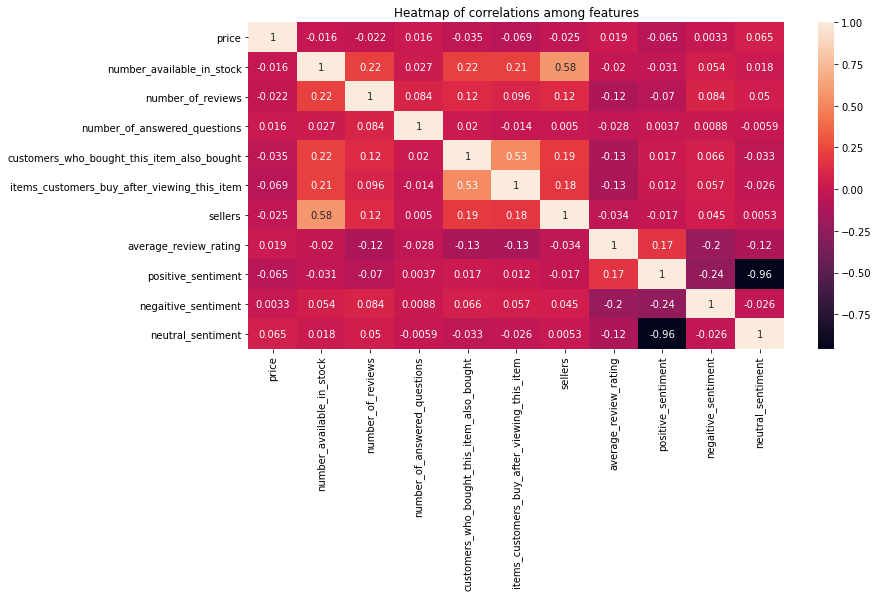

In [187]:
plt.figure(figsize=(12,6))
plt.title('Heatmap of correlations among features')
sns.heatmap(training_data.corr(), annot=True)

Clearly see the relations among features

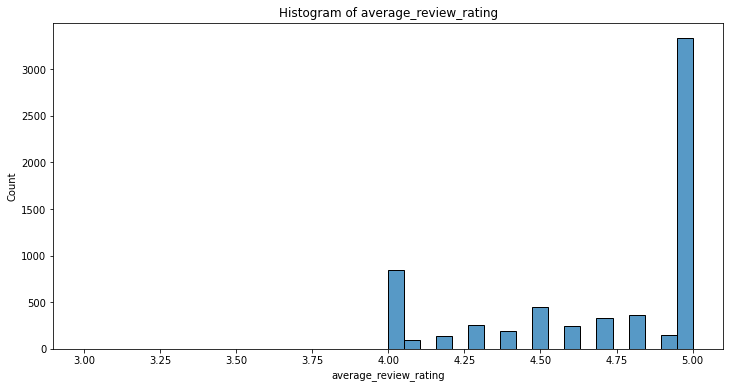

In [188]:
plt.figure(figsize=(12,6))
plt.title('Histogram of average_review_rating')
sns.histplot(training_data['average_review_rating'])

In [145]:
from sklearn.preprocessing import StandardScaler
SC_X = StandardScaler()


In [142]:
cols_to_scale = training_data.describe().iloc[7]>19
cols_to_scale = training_data.columns[cols_to_scale]

In [146]:
training_data[cols_to_scale] = SC_X.fit_transform(training_data[cols_to_scale] )
test_data[cols_to_scale]  = SC_X.fit_transform(test_data[cols_to_scale] )

In [147]:
training_data

,price,number_available_in_stock,number_of_reviews,number_of_answered_questions,customers_who_bought_this_item_also_bought,items_customers_buy_after_viewing_this_item,sellers,average_review_rating,positive_sentiment,negaitive_sentiment,neutral_sentiment
0,-0.108642,-0.744822,-0.154574,-0.281057,6,4,-0.652324,4.5,0.234,0.122,0.644
1,-0.318244,1.024061,1.071266,-0.281057,6,4,-0.926400,4.7,0.253,0.029,0.718
2,-0.323776,-0.508971,-0.211590,-0.281057,6,4,-0.378248,5.0,0.161,0.000,0.839
3,-0.293043,0.316508,0.016473,-0.281057,6,4,1.540284,4.2,0.199,0.029,0.772
4,-0.170928,-0.744822,-0.240098,-0.281057,6,4,-0.926400,4.0,0.287,0.000,0.713
...,...,...,...,...,...,...,...,...,...,...,...
6412,-0.227273,-0.273120,0.928726,0.111872,6,4,0.169904,4.3,0.209,0.022,0.769
6413,-0.079138,-0.508971,-0.240098,-0.281057,1,1,-0.378248,4.0,0.111,0.058,0.832
6414,-0.190188,-0.273120,-0.240098,-0.281057,6,2,-0.926400,5.0,0.066,0.022,0.910
6415,-0.210882,-0.155194,-0.240098,-0.281057,6,4,-0.926400,4.0,0.489,0.022,0.488


In [148]:
test_data

,price,number_available_in_stock,number_of_reviews,number_of_answered_questions,customers_who_bought_this_item_also_bought,items_customers_buy_after_viewing_this_item,sellers,positive_sentiment,negaitive_sentiment,neutral_sentiment
0,-0.214892,-0.730472,-0.236793,-0.284948,1,1,-0.686036,0.224,0.000,0.776
1,-0.398975,-0.623848,-0.107172,-0.284948,6,4,-0.686036,0.145,0.017,0.838
2,-0.490885,-0.197352,0.307613,-0.284948,6,4,-0.957020,0.409,0.000,0.591
3,1.687124,-0.730472,-0.236793,-0.284948,1,1,-0.686036,0.638,0.037,0.325
4,-0.292097,0.762264,0.100220,-0.284948,6,4,-0.957020,0.312,0.042,0.647
...,...,...,...,...,...,...,...,...,...,...
2128,-0.347505,-0.730472,-0.236793,0.565113,6,2,-0.686036,0.112,0.196,0.692
2129,-0.359322,0.122520,0.022448,-0.284948,6,4,1.210853,0.252,0.022,0.726
2130,-0.255858,-0.410600,-0.236793,0.565113,6,4,-0.144068,0.281,0.000,0.719
2131,2.648768,-0.410600,-0.236793,1.415174,6,1,-0.957020,0.276,0.000,0.724


In [ ]:
x_train = training_data.drop('average_review_rating', axis = 1)
y_train = training_data['average_review_rating']

Model 1

In [159]:
from sklearn.svm import SVR
baseline_model = SVR()

param_grid  = [{'kernel':['rbf'], 'degree': [2,3,1], 'gamma': ['scale'], 'coef0':[0.0,0.1], 'tol':[0.001], 'C':[10.0], 'epsilon': [0.1]}]
baseline_model_grid = GridSearchCV(baseline_model,
                        cv = 3,
                        param_grid  = param_grid,
                        n_jobs = -1,
                        verbose=True)
baseline_model_grid.fit(x_train,
         y_train)
print('Baseline Score:  ', baseline_model_grid.best_score_)
print(baseline_model_grid.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   23.6s finished


Baseline Score:   0.03241367413888888
{'C': 10.0, 'coef0': 0.0, 'degree': 2, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf', 'tol': 0.001}


Model 2

In [162]:
from sklearn.metrics import  r2_score
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV



xgb1 = XGBRegressor(random_state=1)
parameters = {'nthread':[4], 
              'learning_rate': [ 0.05], 
              'max_depth': [20],
              'min_child_weight': [3,2,1],
              'silent': [1],
              'subsample': [0.7, 0.6],
              'colsample_bytree': [1],
              'n_estimators': [500,600],
              'objective':['reg:squarederror']
              
              }

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 3,
                        n_jobs = -1,
                        verbose=True)

xgb_grid.fit(x_train,
         y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  6.6min finished


0.07577844313194844
{'colsample_bytree': 1, 'learning_rate': 0.05, 'max_depth': 20, 'min_child_weight': 1, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:squarederror', 'silent': 1, 'subsample': 0.7}


SVR did better than XGB so that is the preferred mmodel

In [164]:
YP= baseline_model_grid.predict(test_data)

In [173]:
YP = pd.DataFrame(YP)
YP.columns = ['predictions']
YP['predictions'] = YP['predictions'].apply(lambda x : round(x,1))
YP['predictions'] = YP['predictions'].apply(lambda x : 5 if x>5 else x)
YP.to_csv('Submission.csv', index=False)

In [174]:
YP.describe()

,predictions
count,2133.000000
mean,4.801266
std,0.152414
min,3.900000
25%,4.800000
50%,4.900000
75%,4.900000
max,5.000000
